In [1]:
from init import *

In [2]:
from rqfactor.extension import UserDefinedLeafFactor,CombinedCrossSectionalFactor

import numpy as np
import pandas as pd

class FAMA(object):
    
    def __init__(self):
        
        #自定义股票收益率因子
        def Stocks_Return(order_book_ids, start_date, end_date):
            return get_price_change_rate(order_book_ids, start_date, end_date).reindex(columns = order_book_ids)
        
        self.stocks_return = UserDefinedLeafFactor('stocks_return', Stocks_Return) 
        self.market_cap = Factor('market_cap_3')
        self.bm = 1/Factor('pb_ratio_lf')
        self.roe=Factor('net_profit_parent_company_ttm_0')/Factor('equity_parent_company_mrq_0')
        self.asset=(Factor('total_assets_mrq_0')-Factor('total_assets_mrq_4'))/ABS(Factor('total_assets_mrq_4'))

    def get_fama_three_factors(self):
        
        def fama_three_factors(stocks_return, market_cap, bm):
            
            bs = market_cap.apply(lambda x: pd.qcut(x, 2, labels=['S','B']), axis=1)
            hml = bm.apply(lambda x: pd.qcut(x, [0, 0.3, 0.7, 1], labels=['L','M','H']), axis=1)
            #smb计算时长：0:01:07.841932
            smb = np.where((bs=='S') & (hml=='L'), 'SL', 
                           np.where((bs=='S') & (hml=='M'), 'SM',
                                    np.where((bs=='S') & (hml=='H'), 'SH',
                                             np.where((bs=='B') & (hml=='L'), 'BL',
                                                      np.where((bs=='B') & (hml=='M'), 'BM',
                                                               np.where((bs=='B') & (hml=='H'), 'BH', np.nan))))))
            
            stocks_return_weighted = stocks_return*market_cap
            sl = np.nansum(np.where(smb == 'SL', stocks_return_weighted, np.nan), axis=1)/np.nansum(market_cap, axis=1)
            sm = np.nansum(np.where(smb == 'SM', stocks_return_weighted, np.nan), axis=1)/np.nansum(market_cap, axis=1)
            sh = np.nansum(np.where(smb == 'SH', stocks_return_weighted, np.nan), axis=1)/np.nansum(market_cap, axis=1)
            bl = np.nansum(np.where(smb == 'BL', stocks_return_weighted, np.nan), axis=1)/np.nansum(market_cap, axis=1)
            bm = np.nansum(np.where(smb == 'BM', stocks_return_weighted, np.nan), axis=1)/np.nansum(market_cap, axis=1)
            bh = np.nansum(np.where(smb == 'BH', stocks_return_weighted, np.nan), axis=1)/np.nansum(market_cap, axis=1)

            fama = pd.DataFrame(data = {'SMB':(sl + sm + sh)/3 - (bl + bm + bh)/3, 'HML':(sh + bh)/2 - (sl + bl)/2},
                                index = stocks_return_weighted.index)
            
            rm = get_price_change_rate('000985.XSHG', stocks_return_weighted.index[0], stocks_return_weighted.index[-1])
            rf = get_yield_curve(stocks_return_weighted.index[0], stocks_return_weighted.index[-1], tenor='0S', market='cn') 
            rb = pd.concat([rm, rf], axis=1)
            rb.columns=['Rm', 'Rf']
            rb['Rb'] = rb['Rm'] - ((rb['Rf'] + 1)** (1/252) - 1)
            
            fama = pd.concat([fama, rb['Rb']], axis=1)
            
            return fama.dropna(how='all')
        
        def FAMA_Three_Factors(*f):
            return CombinedCrossSectionalFactor(fama_three_factors, *f)
        
        ff3 = FAMA_Three_Factors(self.stocks_return, self.market_cap, self.bm)
        return ff3

In [3]:
f = FAMA().get_fama_three_factors()    # 三因子获取
fama_data = execute_factor(f,stock_list,start_date,end_date)

In [4]:
fama_data.to_pickle('fama_data.pkl')

In [5]:
month_date_list = get_trading_dates(fama_data.index[0],end_date)

month_list = []

for i in range(1,len(month_date_list)):
    if month_date_list[i-1].month != month_date_list[i].month:
        month_list.append(month_date_list[i-1])

month_list = pd.to_datetime(month_list)

In [6]:
rf = (get_yield_curve(start_date, end_date, tenor='1Y', market='cn') + 1) ** (1/252) - 1
ret = execute_factor(PCT_CHANGE(Factor('close'),1),stock_list,start_date,end_date)
rp = ret.sub(rf.loc[ret.index,'1Y'].to_list(),axis=0)

### EPU

http://www.policyuncertainty.com/china_monthly.html


In [7]:
epu=pd.read_excel('epu数据.xlsx',sheet_name='EPU 2000 onwards')[['year','month','EPU']]
epu.index = epu.apply(lambda x: str(int(x.year)) + '-' + str(int(x.month)),axis = 1)
epu.index = pd.to_datetime(epu.index)
epu = epu.loc[start_date:]
epu.index = month_list.take(month_list.searchsorted(epu.index, side='right'))
daily_x = pd.concat([epu.EPU,fama_data],axis = 1).ffill().dropna()
#daily_x.to_pickle('daily_x.pkl')

In [8]:
daily_x

,EPU,SMB,HML,Rb
2016-02-29,108.055236,0.004255,0.001084,-0.043682
2016-03-01,108.055236,-0.004244,0.001821,0.020553
2016-03-02,108.055236,-0.009898,0.006569,0.045871
2016-03-03,108.055236,-0.000245,0.001228,0.002364
2016-03-04,108.055236,-0.004834,0.009282,-0.013975
...,...,...,...,...
2023-06-26,233.991581,0.003185,-0.000019,-0.016997
2023-06-27,233.991581,-0.002843,0.002303,0.012013
2023-06-28,233.991581,-0.000245,0.000505,-0.002679
2023-06-29,233.991581,0.001129,-0.000460,0.000584


In [9]:
date_list = pd.to_datetime(daily_x.EPU[daily_x.EPU.diff() != 0].index.tolist())
daily_x_month = daily_x.loc[date_list]

In [10]:
daily_x_month

,EPU,SMB,HML,Rb
2016-02-29,108.055236,0.004255,0.001084,-0.043682
2016-03-31,155.227939,-0.000063,-0.000222,0.001865
2016-04-29,165.238005,0.000520,-0.001137,-0.000945
2016-05-31,117.546431,-0.007659,0.003094,0.037506
2016-06-30,131.457015,-0.000327,0.000160,0.000319
...,...,...,...,...
2023-01-31,275.413596,0.002068,0.002105,-0.004028
2023-02-28,364.287677,-0.001677,0.000435,0.007545
2023-03-31,516.976890,-0.000936,-0.001435,0.006563
2023-04-28,392.605047,-0.002772,0.001144,0.013432


In [11]:
rp_resample_m = rp.resample('M').mean().iloc[:-1]
rp_resample_m.index = date_list.take(date_list.searchsorted(rp_resample_m.index, side='right') - 1)

In [12]:
from sklearn.linear_model import LinearRegression
num = daily_x_month.shape[0]
ts_df = pd.DataFrame()
for i in tqdm(range(12,num)):
    end = daily_x_month.iloc[i].name
    start = daily_x_month.iloc[i-12].name
    rp_temp = rp_resample_m.loc[start:end]
    daily_x_temp = daily_x_month.loc[start:end].dropna()
    x_index = set(daily_x_temp.index)
    cs_dict = {}
    for s in stock_list:
        try:
            rp_temp_stock = rp_temp[s].dropna()
            y_index = set(rp_temp_stock.index)
            inter_index = sorted(list(x_index & y_index))
            x = np.array(daily_x_temp.loc[inter_index])
            y = np.transpose([np.array(rp_temp_stock.loc[inter_index])])
            epu_value = np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)),x.T),y)[0][0]
        except:
            epu_value = np.nan
        cs_dict[s] = epu_value
    cs_df = pd.DataFrame([cs_dict],index = [end])
    ts_df = pd.concat([ts_df,cs_df],axis = 0)

100%|██████████| 76/76 [02:35<00:00,  2.05s/it]


In [23]:
epu_month = ts_df.reindex(pd.to_datetime(get_trading_dates(start_date,end_date))).ffill(limit = 19).dropna(how = 'all')
epu_month = epu_month.mask(~index_fix)
epu_month = data_clean(epu_month)
epu_month.to_pickle('epu_month.pkl')

100%|██████████| 1460/1460 [00:33<00:00, 43.22it/s]


In [24]:
df,ic = Quick_Factor_Return_N_IC(epu_month,20,'epu_month')

{'name': 'epu_month', 'IC mean': 0.0201, 'IC std': 0.092, 'IR': 0.219, 'IR_ly': -0.104, 'IC>0': 0.6056, 'ABS_IC>2%': 0.834, 't_stat': 8.3112}


100%|██████████| 73/73 [00:03<00:00, 20.39it/s]


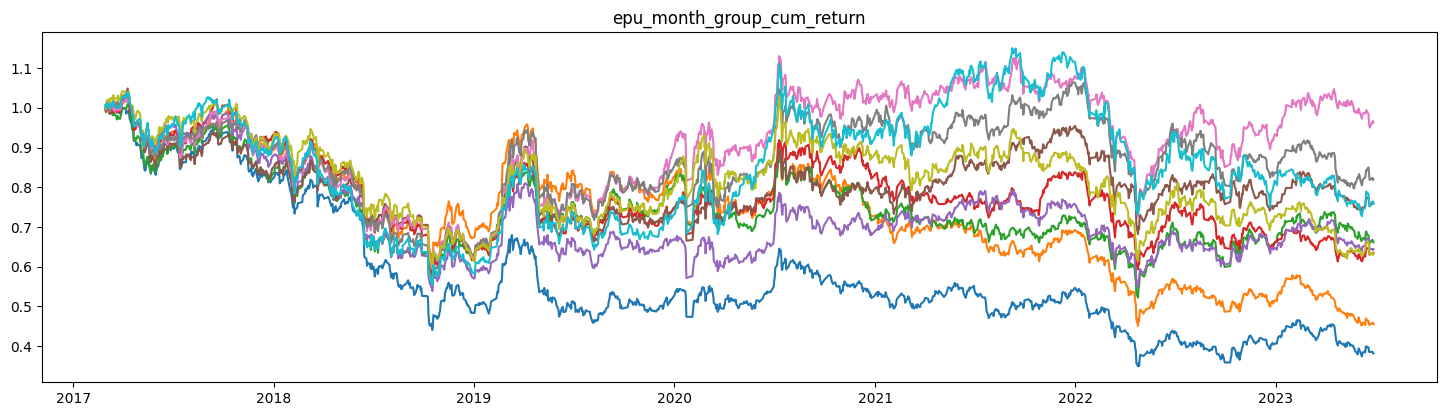

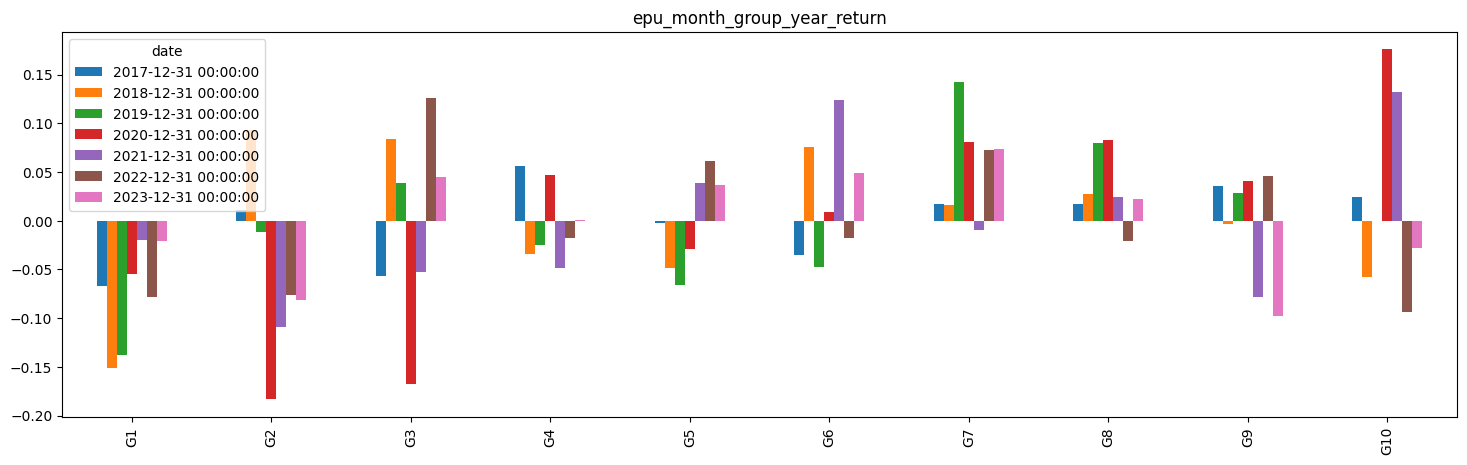

In [25]:
group_return,group_return_year,turnover_ratio = group_g(epu_month,'epu_month')

In [26]:
df,ic = Quick_Factor_Return_N_IC(epu_month.abs(),20,'epu_month')

{'name': 'epu_month', 'IC mean': -0.0314, 'IC std': 0.0829, 'IR': -0.379, 'IR_ly': -0.3368, 'IC>0': 0.3451, 'ABS_IC>2%': 0.8035, 't_stat': -14.3809}


100%|██████████| 73/73 [00:02<00:00, 25.03it/s]


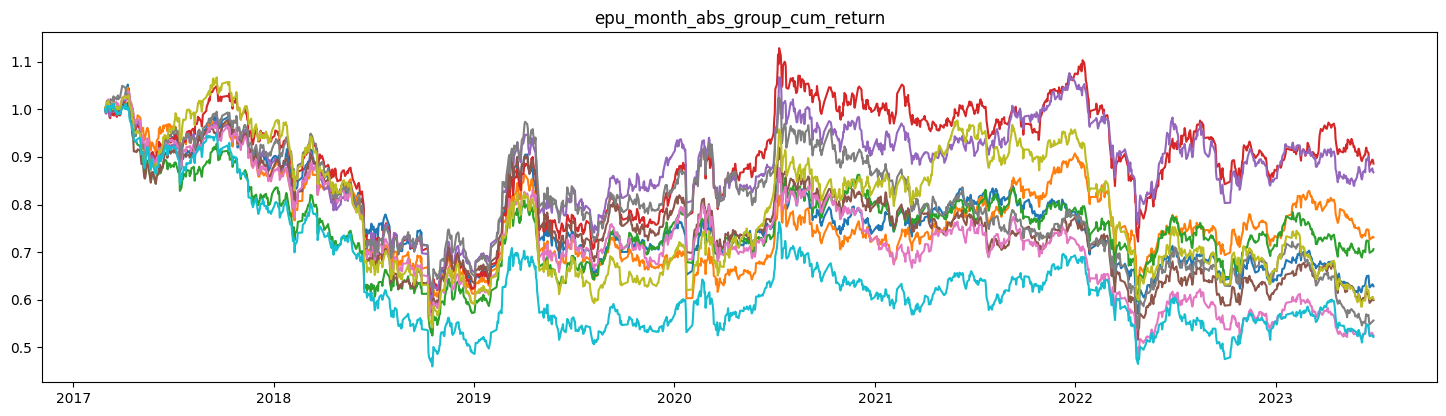

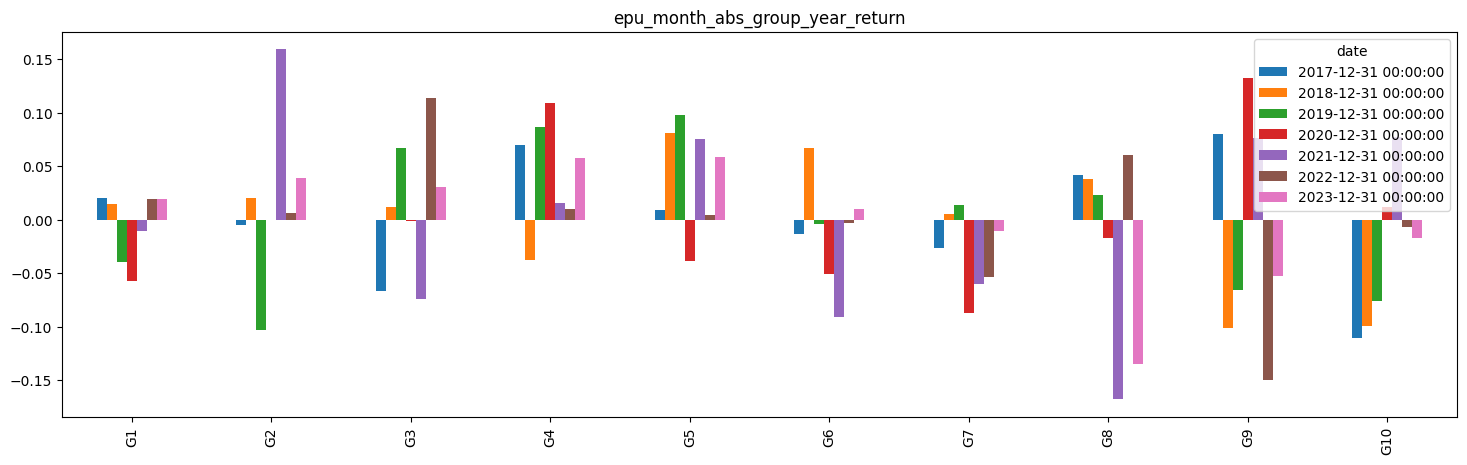

In [27]:
group_return,group_return_year,turnover_ratio = group_g(epu_month.abs(),'epu_month_abs')

### 课后作业：['GDP','CPI','SF','M2','PMI']

https://data.stats.gov.cn/

In [30]:
dataset = pd.read_excel('宏观指标.xlsx',index_col=[0],parse_dates=[0]).iloc[2:-1]
dataset.index = pd.to_datetime(dataset.index )
dataset.columns = ['GDP','CPI','SF','M2','PMI']
dataset = dataset.sort_index().loc['2010-01-01':]

In [31]:
dataset

,GDP,CPI,SF,M2,PMI
指标名称,,,,,
2010-01-31,NaN,1.53,13934,625609.29,55.8
2010-02-28,NaN,2.7,20933,636072.26,52
2010-03-31,87501.3,2.37,26040,649947.46,55.1
2010-04-30,NaN,2.81,33780,656561.22,55.7
2010-05-31,NaN,3.06,40273,663351.37,53.9
...,...,...,...,...,...
2023-02-28,NaN,1,67498,2755249.23,52.6
2023-03-31,284996.6,0.7,106985,2814566.31,51.9
2023-04-30,NaN,0.1,111416,2808469.34,49.2
